In [2]:
!pip3 install dgl

In [3]:
#Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import torch.nn as nn
import dgl.function as fn
from dgl import DGLGraph
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import torch.nn.functional as F
import torch
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
#Reading the dataset
df_malware = pd.read_csv('/content/Nihal_Dataset.csv')
df_malware.head()

,Name,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,...,SectionMaxChar,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
0,VirusShare_a878ba26000edaac5c98eff4432723b3,23117,144,3,0,4,0,65535,0,184,...,3758096608,0,7,152,0,0,54440,77824,73728,0
1,VirusShare_ef9130570fddc174b312b2047f5f4cf0,23117,144,3,0,4,0,65535,0,184,...,3791650880,0,16,311,0,0,262276,294912,0,346112
2,VirusShare_ef84cdeba22be72a69b198213dada81a,23117,144,3,0,4,0,65535,0,184,...,3221225536,0,6,176,0,0,36864,40960,0,0
3,VirusShare_6bf3608e60ebc16cbcff6ed5467d469e,23117,144,3,0,4,0,65535,0,184,...,3224371328,0,8,155,0,0,356352,1003520,0,14109472
4,VirusShare_2cc94d952b2efb13c7d6bbe0dd59d3fb,23117,144,3,0,4,0,65535,0,184,...,3227516992,0,2,43,0,0,61440,73728,0,90624


In [5]:
#Columns check of dataset
df_malware.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19611 entries, 0 to 19610
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          19611 non-null  object 
 1   e_magic                       19611 non-null  int64  
 2   e_cblp                        19611 non-null  int64  
 3   e_cp                          19611 non-null  int64  
 4   e_crlc                        19611 non-null  int64  
 5   e_cparhdr                     19611 non-null  int64  
 6   e_minalloc                    19611 non-null  int64  
 7   e_maxalloc                    19611 non-null  int64  
 8   e_ss                          19611 non-null  int64  
 9   e_sp                          19611 non-null  int64  
 10  e_csum                        19611 non-null  int64  
 11  e_ip                          19611 non-null  int64  
 12  e_cs                          19611 non-null  int64  
 13  e

In [6]:
#Checking the null values
df_malware.isnull().sum()

Name                            0
e_magic                         0
e_cblp                          0
e_cp                            0
e_crlc                          0
                               ..
ImageDirectoryEntryExport       0
ImageDirectoryEntryImport       0
ImageDirectoryEntryResource     0
ImageDirectoryEntryException    0
ImageDirectoryEntrySecurity     0
Length: 79, dtype: int64

In [7]:
#Statistical description of dataset
df_malware.describe()

,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SectionMaxChar,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
count,19611.0,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.00000,19611.000000,...,1.961100e+04,19611.0,19611.000000,19611.000000,19611.000000,1.961100e+04,1.961100e+04,1.961100e+04,1.961100e+04,1.961100e+04
mean,23117.0,178.615726,71.660752,49.146958,37.370710,37.032635,64178.739687,10.418490,226.46530,29.689103,...,3.163632e+09,0.0,6.112437,101.912804,14.131865,3.368566e+05,4.047213e+05,5.555810e+05,1.238834e+06,8.814868e+05
std,0.0,987.200729,1445.192977,1212.201919,864.515405,915.833139,9110.755873,637.116265,1249.68033,1015.303419,...,5.860332e+08,0.0,7.525158,127.076767,154.958102,2.181191e+07,4.704601e+06,6.772167e+06,5.868961e+07,2.167579e+07
min,23117.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.073742e+09,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.00000,0.000000,...,3.221226e+09,0.0,2.000000,17.000000,0.000000,0.000000e+00,2.960400e+04,4.096000e+04,0.000000e+00,0.000000e+00
50%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.00000,0.000000,...,3.221226e+09,0.0,4.000000,80.000000,0.000000,0.000000e+00,8.222400e+04,1.310720e+05,0.000000e+00,0.000000e+00
75%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.00000,0.000000,...,3.221226e+09,0.0,8.000000,135.000000,0.000000,0.000000e+00,2.477080e+05,3.870720e+05,0.000000e+00,3.184640e+05
max,23117.0,59448.000000,63200.000000,64613.000000,43690.000000,43690.000000,65535.000000,61436.000000,65464.00000,63262.000000,...,4.294967e+09,0.0,588.000000,4016.000000,7319.000000,2.147484e+09,5.368914e+08,8.304108e+08,2.906159e+09,2.415919e+09


In [8]:
#Dropping the unwanted columns from the dataset
df_malware_f = df_malware.drop(['Name','Machine','TimeDateStamp'], axis=1)

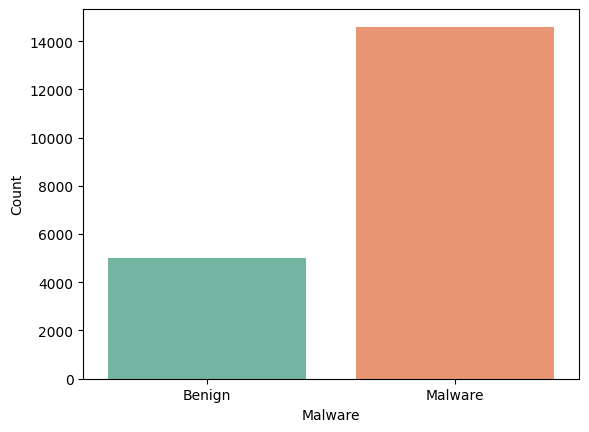

In [9]:
# Creating the count plot with 'Malware' as x-axis
sns.countplot(data=df_malware_f, x='Malware', palette='Set2')
# Set x-axis tick labels
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malware'])
# Set labels for the axes
plt.xlabel('Malware')
plt.ylabel('Count')
# Show the plot
plt.show()


In [10]:
#Displaying top 5 rows of dataset
df_malware_f.head()

,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SectionMaxChar,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
0,23117,144,3,0,4,0,65535,0,184,0,...,3758096608,0,7,152,0,0,54440,77824,73728,0
1,23117,144,3,0,4,0,65535,0,184,0,...,3791650880,0,16,311,0,0,262276,294912,0,346112
2,23117,144,3,0,4,0,65535,0,184,0,...,3221225536,0,6,176,0,0,36864,40960,0,0
3,23117,144,3,0,4,0,65535,0,184,0,...,3224371328,0,8,155,0,0,356352,1003520,0,14109472
4,23117,144,3,0,4,0,65535,0,184,0,...,3227516992,0,2,43,0,0,61440,73728,0,90624


In [11]:
# Features to visualize
features = ['MajorSubsystemVersion', 'MajorLinkerVersion', 'SizeOfCode', 'SizeOfImage', 'SizeOfHeaders',
            'SizeOfInitializedData', 'SizeOfUninitializedData', 'SizeOfStackReserve',
            'SizeOfHeapReserve', 'NumberOfSymbols', 'SectionMaxChar']

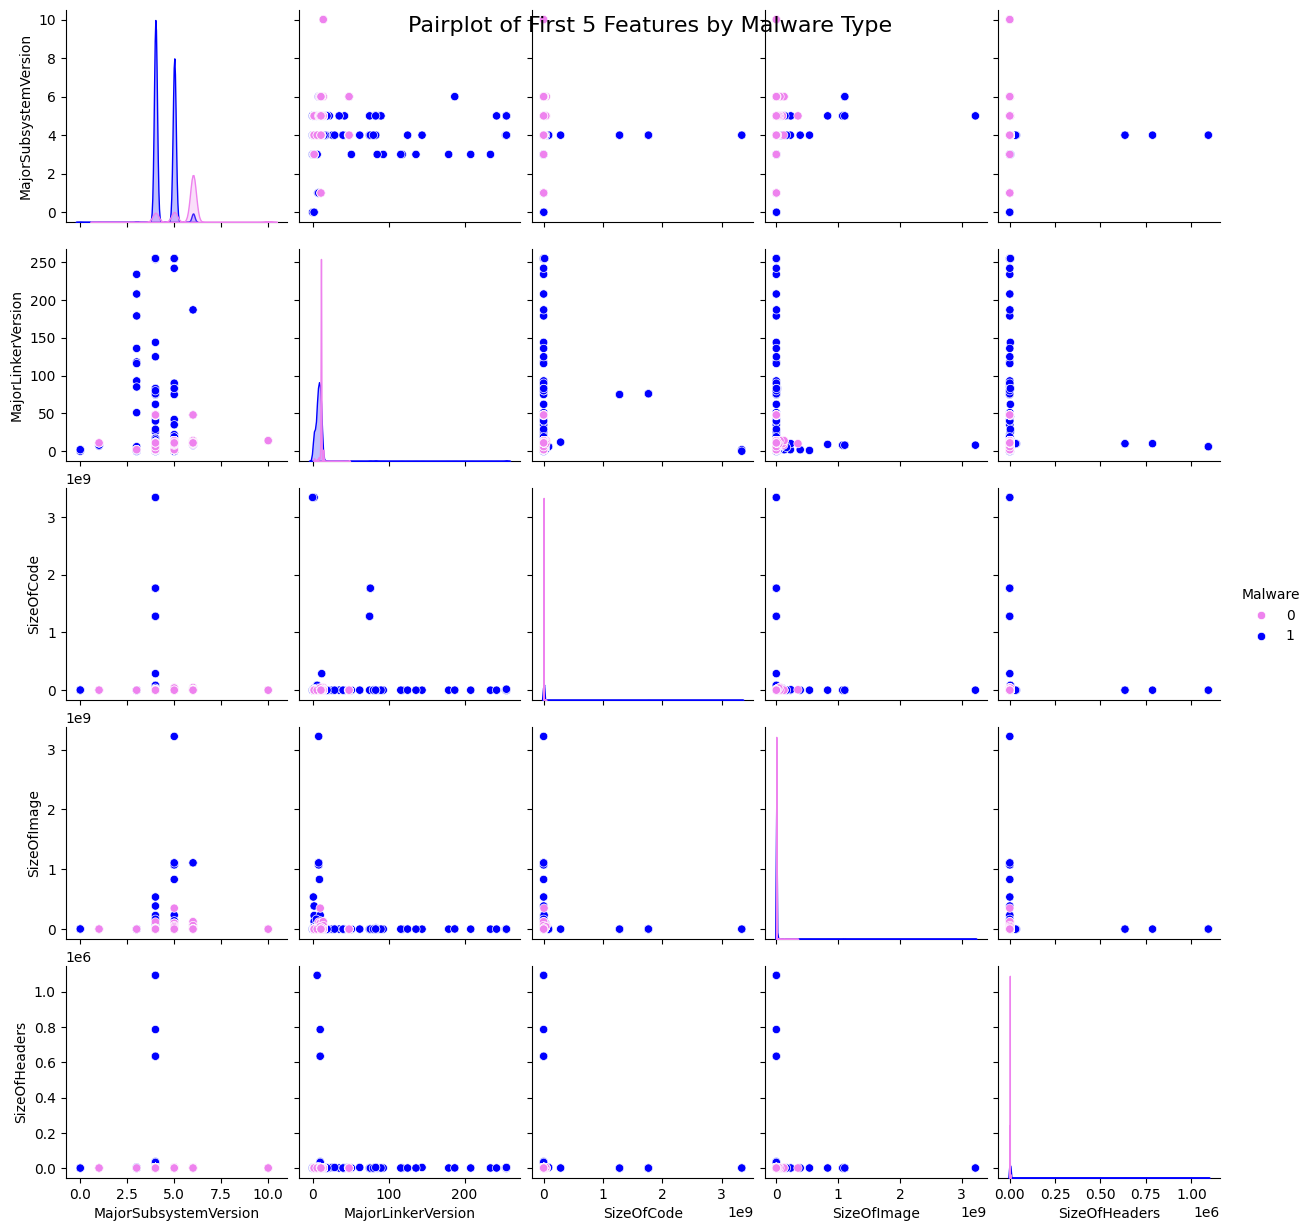

In [12]:
# Splitting the features list into two subsets
features_subset1 = features[:5]  # First 5 columns
features_subset2 = features[5:]  # Next 6 columns
palette = {1: 'blue', 0: 'violet'}
# Create separate pairplots for each subset
sns.pairplot(data=df_malware_f, hue='Malware', vars=features_subset1, palette=palette)
plt.suptitle('Pairplot of First 5 Features by Malware Type', size=16)
plt.show()

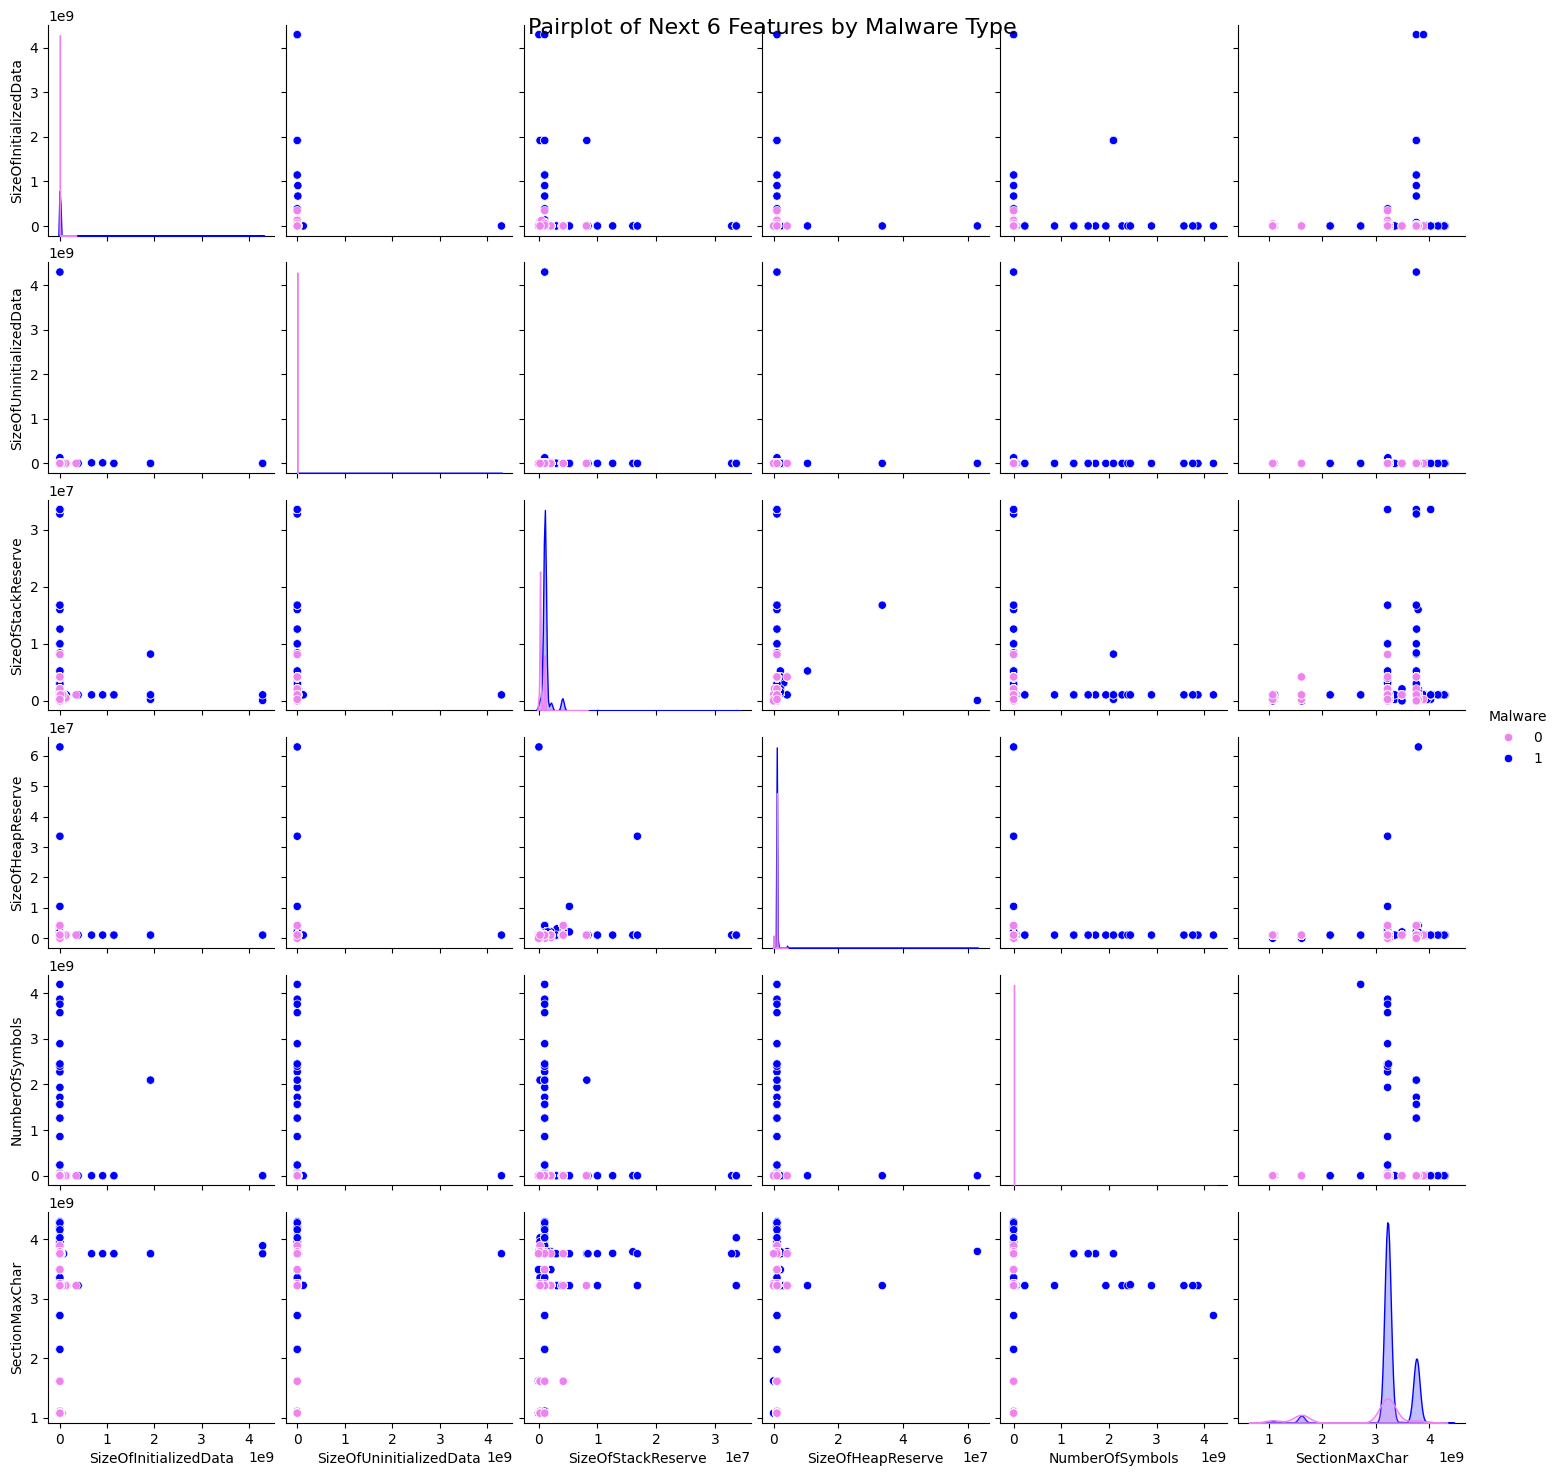

In [13]:
#Pairplot
sns.pairplot(data=df_malware_f, hue='Malware', vars=features_subset2, palette=palette)
plt.suptitle('Pairplot of Next 6 Features by Malware Type', size=16)
plt.show()

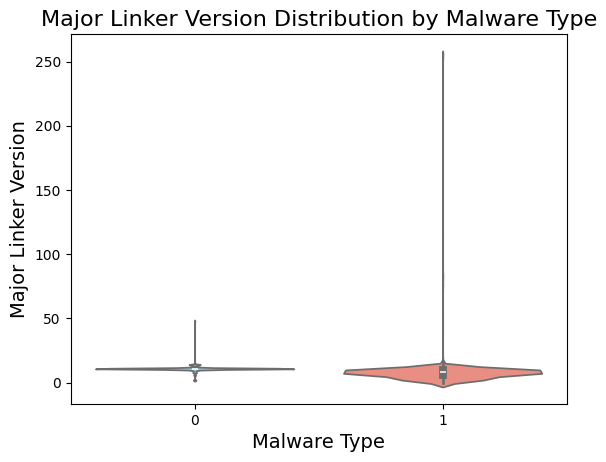

In [14]:
#Violinplot
sns.violinplot(data=df_malware_f, x='Malware', y='MajorLinkerVersion', palette=['skyblue', 'salmon'])
plt.xlabel('Malware Type', fontsize=14)
plt.ylabel('Major Linker Version', fontsize=14)
plt.title('Major Linker Version Distribution by Malware Type', fontsize=16)
plt.show()

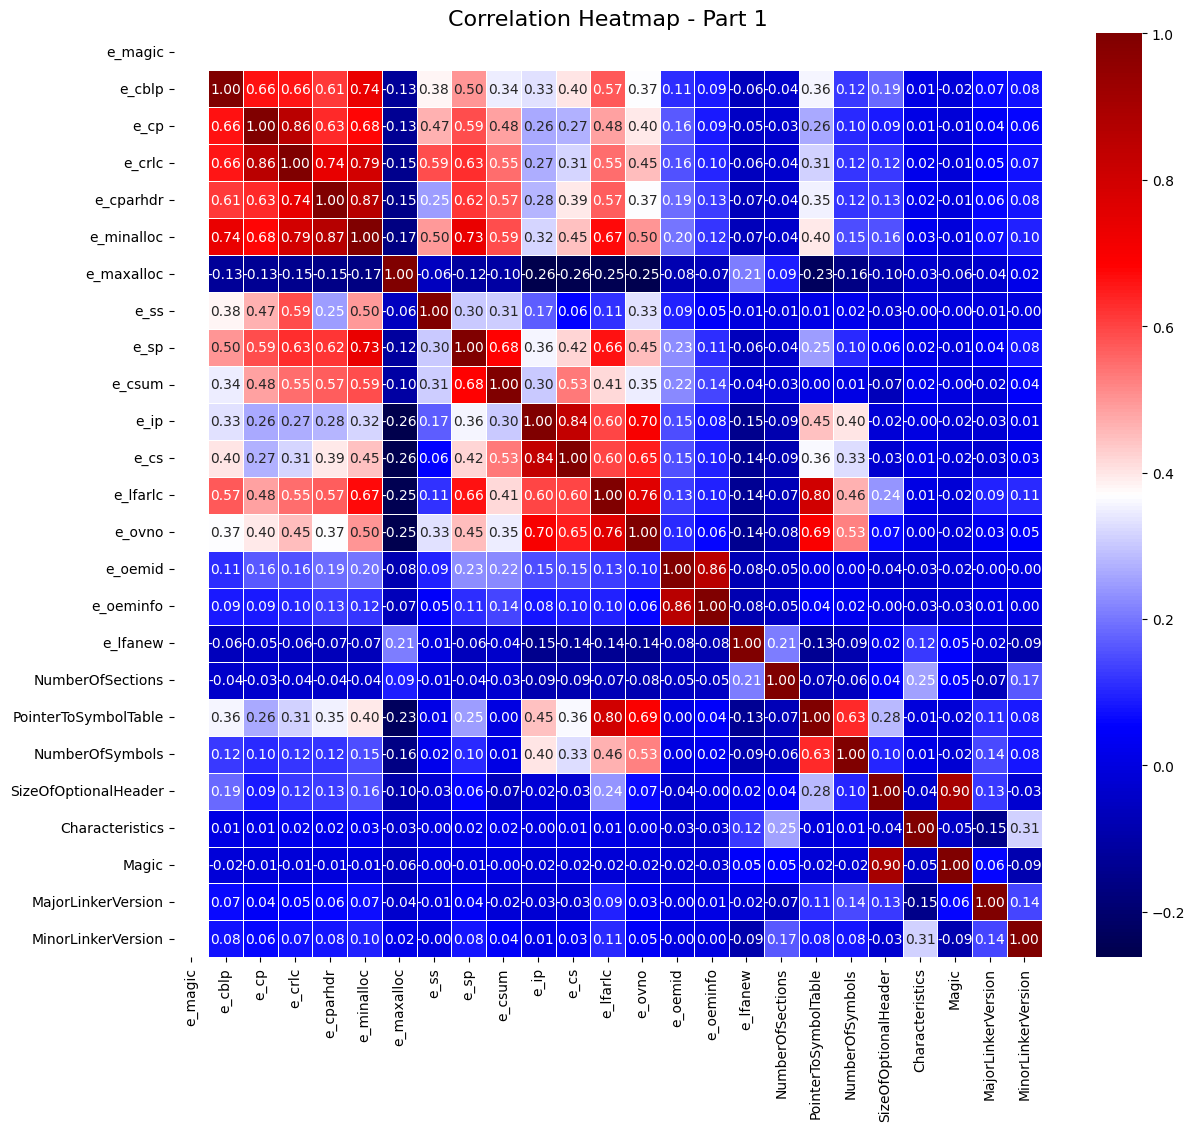

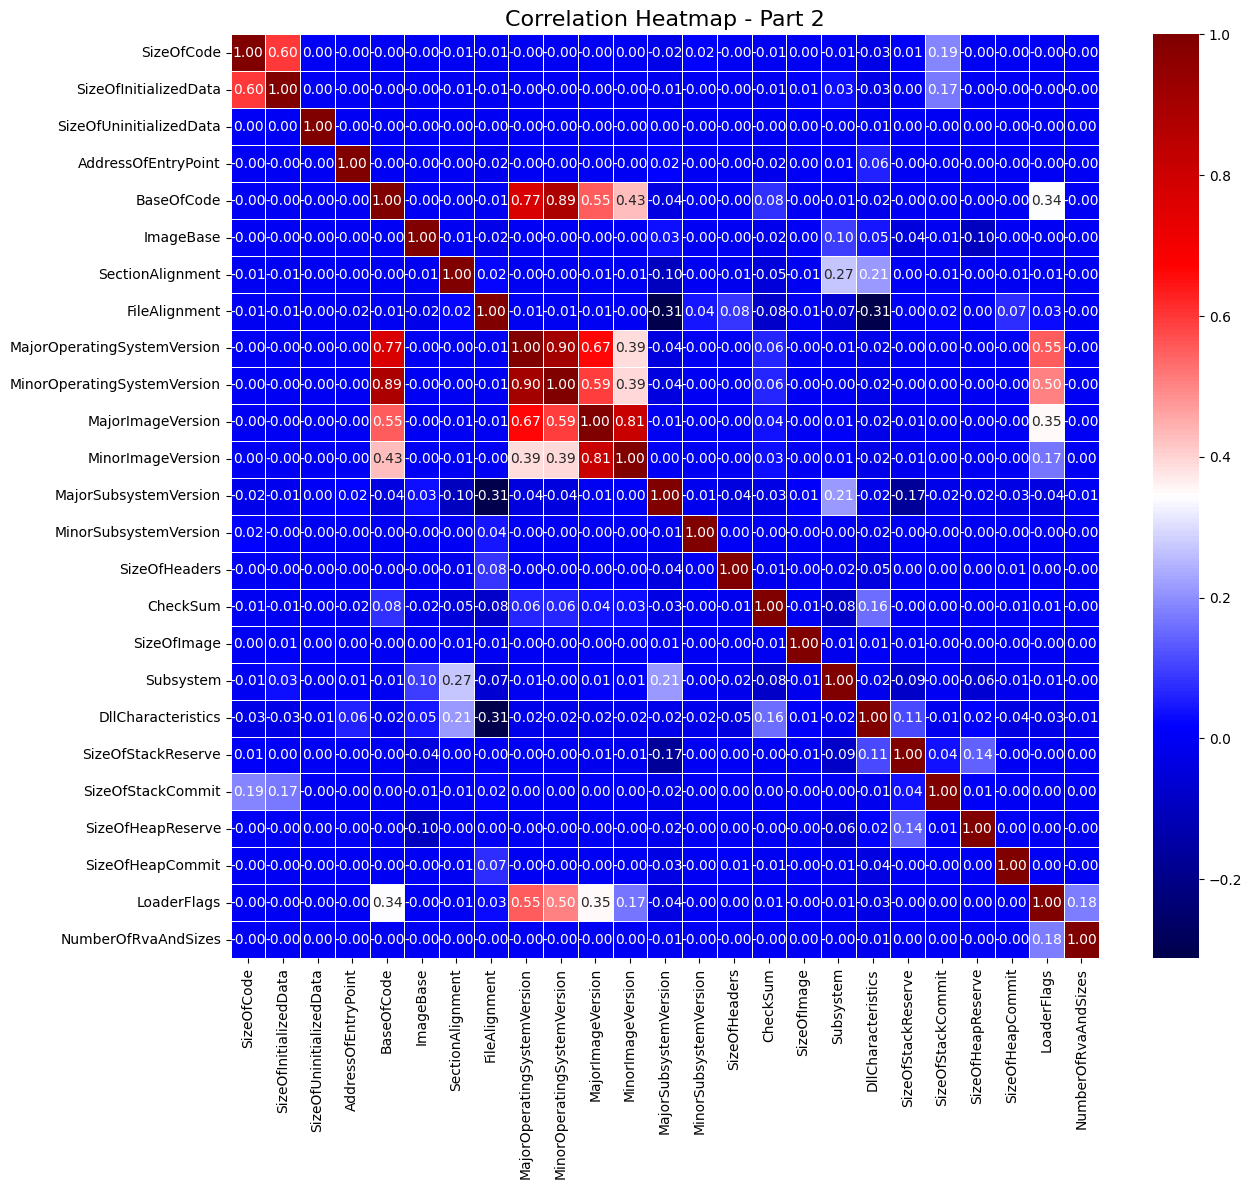

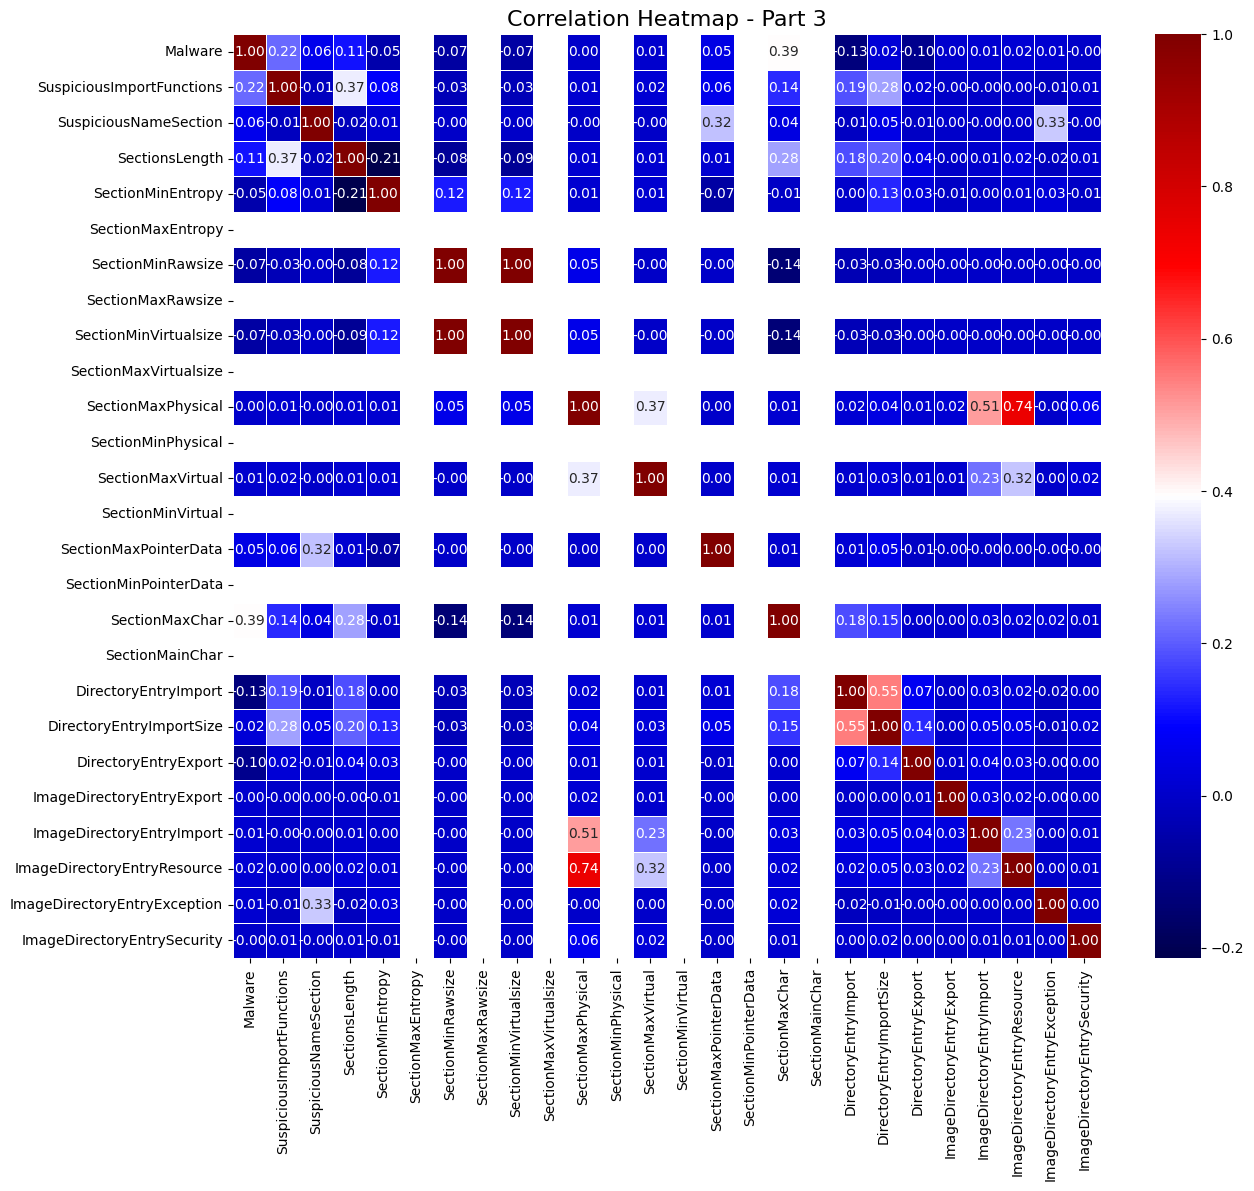

In [15]:
# Splitting the columns into three sections
num_cols = len(df_malware_f.columns)
section_sizes = [25, 25, 26]

# Creating separate correlation matrices for each section
corr_sections = [
    df_malware_f.iloc[:, sum(section_sizes[:i]):sum(section_sizes[:i + 1])].corr()
    for i in range(len(section_sizes))
]

# Creating separate correlation heatmaps for each section
for i, corr_section in enumerate(corr_sections):
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_section, annot=True, cmap='seismic', fmt=".2f", linewidths=0.5)
    plt.title(f'Correlation Heatmap - Part {i + 1}', fontsize=16)
    plt.show()

In [16]:
#Separating the dependent and independent variables
X = df_malware_f.drop(['Malware'] , axis = 1)
y = df_malware_f['Malware']

In [17]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Using SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)